In [26]:
import pandas as pd
import numpy as np

# Create a date range
date = pd.date_range(start='2020-01-01', end='2020-02-28')

# Create a DataFrame
df = pd.DataFrame({'date': date, 'value': np.random.rand(len(date))})

# Compute rolling average
df['value_rolling'] = df['value'].rolling(window=30).mean()

# Shift the result backward
df['value_rolling'] = df['value_rolling'].shift(-29)

# Create 'date_last (rolling)' column
df['date_last (rolling)'] = df['date'].shift(-29)

# Print the result
display(df)

,date,value,value_rolling,date_last (rolling)
0,2020-01-01,0.871432,0.455629,2020-01-30
1,2020-01-02,0.084484,0.455598,2020-01-31
2,2020-01-03,0.488312,0.473149,2020-02-01
3,2020-01-04,0.430945,0.474377,2020-02-02
4,2020-01-05,0.399359,0.480661,2020-02-03
5,2020-01-06,0.486221,0.483293,2020-02-04
6,2020-01-07,0.056359,0.480780,2020-02-05
7,2020-01-08,0.448405,0.483542,2020-02-06
8,2020-01-09,0.551333,0.471135,2020-02-07
9,2020-01-10,0.698390,0.473359,2020-02-08


In [28]:
df.to_csv('data/test.csv', index=None)

---

# Start Here

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import timedelta

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [2]:
ftse_price_df = pd.read_csv('files/1-FTSE_PRICES_2006-2022-FINAL.csv')
ftse_price_df = ftse_price_df.iloc[:, 1:]
ftse_price_df['Month'] = ftse_price_df['Date'].astype(str).apply(lambda x: x[:8] + '01')

unique_assets_lists = ftse_price_df.Asset.unique()
unique_assets_str_lists = [str(i) for i in unique_assets_lists]

In [3]:
# preprocess columns additions and arrangements
coverage_df = v4.coverage_equ([-1])

coverage_shortlist_df = coverage_df[coverage_df.PermID.isin(unique_assets_str_lists)]
coverage_shortlist_df = coverage_shortlist_df[['PermID','Ticker','RIC']]
coverage_shortlist_df['PermID'] = coverage_shortlist_df['PermID'].astype(int)

temp_cols = coverage_shortlist_df.columns.tolist()
temp_cols2 = ftse_price_df.drop(['Asset'], axis=1).columns.tolist()
temp_cols_fin = ['Asset'] + temp_cols + temp_cols2

ftse_price_df = pd.merge(ftse_price_df, coverage_shortlist_df, how = 'left', left_on = 'Asset', right_on='PermID')
ftse_price_df = ftse_price_df[temp_cols_fin]

In [4]:
# The calculation based on: A Volatility Estimator of Stock Market Indices Based on the Intrinsic Entropy Model.
# https://arxiv.org/pdf/2205.01370.pdf

def normalised_open(df):
    """
    Normalised opening price
    """
    
    return np.log(df['Open'] / df['Close_t-1'])

def normalised_up(df):
    """
    Normalised high of the current period
    """
    
    return np.log(df['High'] / df['Open'])

def normalised_down(df):
    """
    Normalised low of the current period
    """
    
    return np.log(df['Low'] / df['Open'])

def normalised_close(df):
    """
    Normalised close of the current period
    """
    
    return np.log(df['Close'] / df['Open'])

In [5]:
def func_Vol_YangZhang(df, rolling = 30, blank_days = 30, assets = 'Asset'):
    
    cols = ['Month', 'Date', 'Asset', 'Currency']    
    k = 0.34 / (1.34 + (rolling + 1) / (rolling - 1))
    
    unique_assets_list = df[assets].unique()
    volatility_df = pd.DataFrame()

    df.loc[:, 'Date'] = pd.to_datetime(df['Date'])
    
    for asset in unique_assets_list:

        
        slice_df = df[df[assets] == asset].copy()

        # define the group based on jump on record
        slice_df.loc[:,'Jump'] = slice_df['Date'].diff() > timedelta(days=blank_days)
        slice_df.loc[:,'Group'] = slice_df['Jump'].cumsum()

        # Ordinary Volatility
        slice_df.loc[:,'Return'] = slice_df.groupby('Group')['Close'].pct_change()
        
        ### === Properties of RS === ###
        slice_df['Close_t-1'] = slice_df.groupby('Group')['Close'].shift(1)

        if len(slice_df.Group.unique()) > 1:

            slice_df['O_i'] = slice_df.groupby('Group').apply(normalised_open).droplevel('Group')
            slice_df['u_i'] = slice_df.groupby('Group').apply(normalised_up).droplevel('Group')
            slice_df['d_i'] = slice_df.groupby('Group').apply(normalised_down).droplevel('Group')
            slice_df['c_i'] = slice_df.groupby('Group').apply(normalised_close).droplevel('Group')

        else:
            slice_df['O_i'] = slice_df.groupby('Group').apply(normalised_open).T
            slice_df['u_i'] = slice_df.groupby('Group').apply(normalised_up).T
            slice_df['d_i'] = slice_df.groupby('Group').apply(normalised_down).T
            slice_df['c_i'] = slice_df.groupby('Group').apply(normalised_close).T
            

        ### === Properties of YZ (OLD with STDev) === ### 
        slice_df['V^O'] = slice_df.groupby('Group')['O_i'].rolling(window=rolling).std().droplevel('Group')
        slice_df['V^C'] = slice_df.groupby('Group')['c_i'].rolling(window=rolling).std().droplevel('Group')
        
        ### === Royal-Satchell Calculation #1 === ###
        slice_df['temp_RS'] = (slice_df['u_i'] * (slice_df['u_i'] - slice_df['c_i'])) + (slice_df['d_i'] * (slice_df['d_i'] - slice_df['c_i']))

        ### === Close to Close Calculation === ###
        slice_df.loc[:,'V^CC'] = slice_df.groupby('Group')['Return'].rolling(window=rolling).std().droplevel('Group')

        ### === Royal-Satchell Calculation #2 === ###
        slice_df['V^RS'] = slice_df.groupby('Group')['temp_RS'].rolling(window=rolling).mean().droplevel('Group')
        slice_df['V^RS'] = np.sqrt(slice_df['V^RS'])

        ### === Yang-Zhang Calculation #1 === ###
        slice_df['V^YZ'] = np.sqrt(pow(slice_df['V^O'],2) + k*pow(slice_df['V^C'],2) + (1-k)*pow(slice_df['V^RS'],2))

        slice_df['V^YZ'] = slice_df['V^YZ'].shift((rolling*-1)+1)
        slice_df['V^RS'] = slice_df['V^RS'].shift((rolling*-1)+1)
        slice_df['V^CC'] = slice_df['V^CC'].shift((rolling*-1)+1)
        slice_df['Date (shifted)'] = slice_df['Date'].shift((rolling*-1)+1)

        volatility_df = pd.concat([volatility_df,slice_df])

    try:
        cols_arranged = volatility_df.drop(cols, axis=1).columns.tolist()
        cols = cols + cols_arranged
    except:
        cols = volatility_df.columns
    
    return volatility_df[cols]

<Axes: xlabel='Date (shifted)'>

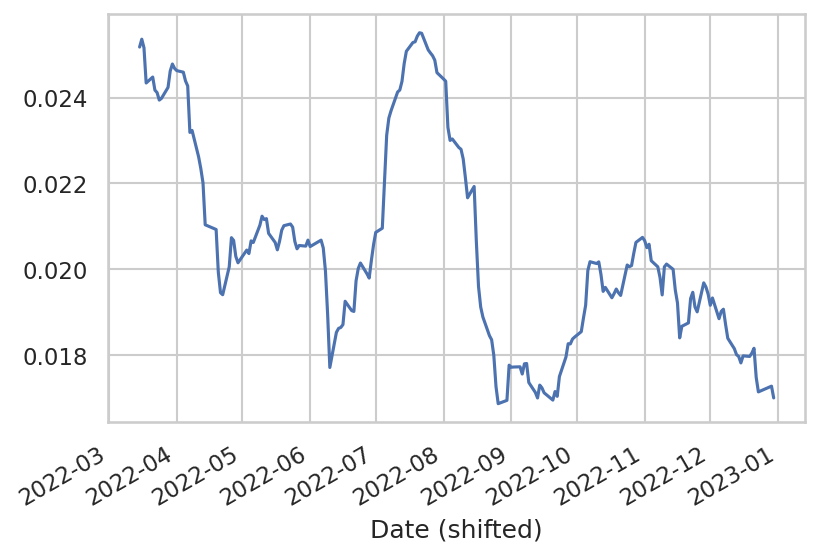

In [11]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 30)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ (shifted)'].notnull())].iloc[(-200):, -2].plot()

In [7]:
ftse_volprice_df[ftse_volprice_df['V^YZ'].notnull()].to_csv('files/1.1-FTSE_VOL21-PRICES_2006-2022.csv', index=None)

In [8]:
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].head(5)

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ,Date (shifted)
Date (shifted),,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-02-01,2006-01-01,2006-01-04 00:00:00,4295885039,GBP,4295885039,SHEL,SHEL.L,18.339996,18.439986,18.289993,18.289993,3463883.0,18.289993,False,0,0.001095,18.269988,0.003825,0.005437,-0.002730,-0.002730,NaN,NaN,0.000044,0.008094,0.008891,0.009532,2006-02-01 00:00:00
2006-02-02,2006-01-01,2006-01-05 00:00:00,4295885039,GBP,4295885039,SHEL,SHEL.L,18.349991,18.509993,18.259993,18.289993,5352692.0,18.289993,False,0,0.000000,18.289993,0.003275,0.008682,-0.004917,-0.003275,NaN,NaN,0.000112,0.009853,0.008905,0.009865,2006-02-02 00:00:00
2006-02-03,2006-01-01,2006-01-06 00:00:00,4295885039,GBP,4295885039,SHEL,SHEL.L,18.259993,18.500000,18.259993,18.479996,6060457.0,18.479996,False,0,0.010388,18.289993,-0.001642,0.013058,0.000000,0.011976,NaN,NaN,0.000014,0.010072,0.008927,0.009851,2006-02-03 00:00:00
2006-02-06,2006-01-01,2006-01-09 00:00:00,4295885039,GBP,4295885039,SHEL,SHEL.L,18.429993,18.659988,18.359986,18.409988,5906313.0,18.409988,False,0,-0.003788,18.479996,-0.002709,0.012402,-0.003806,-0.001086,NaN,NaN,0.000178,0.009862,0.008979,0.009874,2006-02-06 00:00:00
2006-02-07,2006-01-01,2006-01-10 00:00:00,4295885039,GBP,4295885039,SHEL,SHEL.L,18.349991,18.439986,18.269988,18.359986,4838832.0,18.359986,False,0,-0.002716,18.409988,-0.003264,0.004892,-0.004369,0.000545,NaN,NaN,0.000043,0.010315,0.008705,0.009715,2006-02-07 00:00:00


---

<Axes: xlabel='Date'>

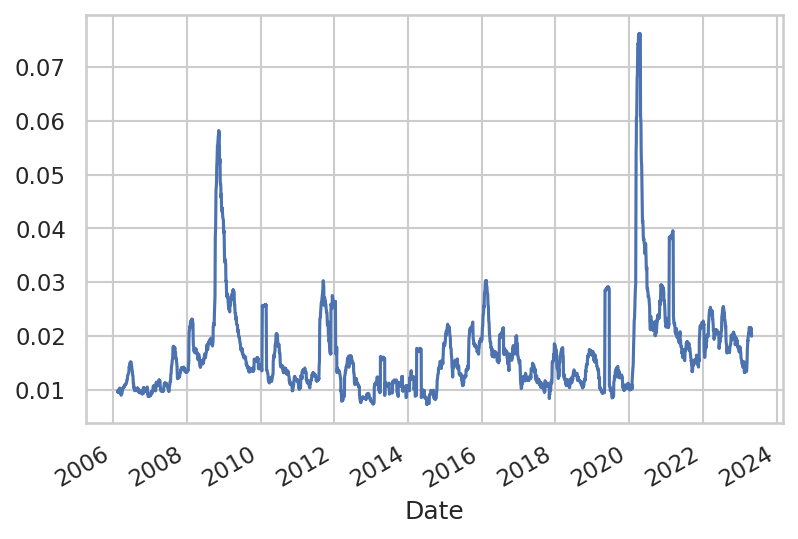

In [23]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 30)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df.Date)
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())]['V^YZ'].plot()

In [11]:
ftse_volprice_df.head()

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
0,2006-01-01,2006-01-03 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.384185,9.486490,9.365584,9.486490,2.503309e+06,10.20,False,0,NaN,NaN,NaN,0.010843,-0.001984,0.010843,NaN,NaN,0.000025,NaN,NaN,NaN
1,2006-01-01,2006-01-04 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.505091,9.663199,9.505091,9.616697,2.410045e+06,10.34,False,0,0.013725,9.486490,0.001959,0.016497,0.000000,0.011673,NaN,NaN,0.000080,NaN,NaN,NaN
2,2006-01-01,2006-01-05 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.700401,9.746904,9.625997,9.663199,4.212039e+06,10.39,False,0,0.004836,9.616697,0.008666,0.004782,-0.007700,-0.003842,NaN,NaN,0.000071,NaN,NaN,NaN
3,2006-01-01,2006-01-06 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.598096,9.616697,9.505091,9.560894,3.953997e+06,10.28,False,0,-0.010587,9.663199,-0.006760,0.001936,-0.009737,-0.003884,NaN,NaN,0.000068,NaN,NaN,NaN
4,2006-01-01,2006-01-09 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.598096,9.653899,9.598096,9.625997,3.145075e+06,10.35,False,0,0.006809,9.560894,0.003884,0.005797,0.000000,0.002903,NaN,NaN,0.000017,NaN,NaN,NaN


In [12]:
ftse_volprice_df[ftse_volprice_df['V^YZ'].notnull()]

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
1972,2006-02-01,2006-02-02 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.244677,9.421387,9.244677,9.384185,2.712857e+07,10.090000,False,0,0.016113,9.235377,0.001007,0.018934,0.000000,0.014978,0.004748,0.008105,0.000075,0.010174,0.008602,0.009766
1973,2006-02-01,2006-02-03 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.272579,9.300481,9.170274,9.281879,1.709742e+07,9.980000,False,0,-0.010902,9.384185,-0.011964,0.003005,-0.011094,0.001003,0.005318,0.007661,0.000140,0.009871,0.008768,0.010130
1974,2006-02-01,2006-02-06 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.207476,9.226076,9.151672,9.160973,8.462541e+06,9.849999,False,0,-0.013026,9.281879,-0.008048,0.002018,-0.006079,-0.005063,0.005007,0.007693,0.000020,0.010053,0.008630,0.009870
1975,2006-02-01,2006-02-07 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.207476,9.272579,9.160973,9.226076,3.171200e+06,9.919999,False,0,0.007107,9.160973,0.005063,0.007046,-0.005063,0.002018,0.005110,0.007672,0.000071,0.010082,0.008638,0.009926
1976,2006-02-01,2006-02-08 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.188874,9.253978,8.984264,9.077268,5.376974e+06,9.759999,False,0,-0.016129,9.226076,-0.004040,0.007060,-0.022519,-0.012220,0.004988,0.008061,0.000368,0.010359,0.009557,0.010609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419476,2023-04-01,2023-04-24 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,5.824998,5.875000,5.784998,5.829998,1.055470e+06,5.829998,False,0,-0.004270,5.854998,-0.005137,0.008547,-0.006891,0.000858,0.009280,0.014796,0.000119,0.015748,0.017803,0.019734
419477,2023-04-01,2023-04-25 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,5.829998,5.880000,5.760000,5.850000,1.146753e+06,5.850000,False,0,0.003431,5.829998,0.000000,0.008540,-0.012079,0.003425,0.009101,0.014152,0.000231,0.015558,0.017781,0.019567
419478,2023-04-01,2023-04-26 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,5.829998,5.854998,5.774998,5.824998,1.103733e+06,5.824998,False,0,-0.004274,5.850000,-0.003425,0.004279,-0.009479,-0.000858,0.009154,0.013654,0.000104,0.015411,0.017445,0.019279
419479,2023-04-01,2023-04-27 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,5.840000,5.869998,5.795000,5.800000,1.492516e+06,5.800000,False,0,-0.004291,5.824998,0.002572,0.005123,-0.007735,-0.006873,0.009094,0.013690,0.000068,0.015390,0.017427,0.019240


In [9]:
ftse_volprice_df[ftse_volprice_df.Asset == 5050718643]

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
353788,2006-01-01,2006-01-03 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,0.883526,0.895498,0.881132,0.895498,4.489680e+03,0.935000,False,0,NaN,NaN,NaN,0.013459,-0.002714,0.013459,NaN,NaN,0.000044,NaN,NaN,NaN
353789,2006-01-01,2006-01-04 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,0.883526,0.919442,0.883526,0.919442,1.150782e+06,0.960000,False,0,0.026738,0.895498,-0.013459,0.039846,0.000000,0.039846,NaN,NaN,0.000000,NaN,NaN,NaN
353790,2006-01-01,2006-01-05 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,0.919442,0.919442,0.909864,0.919442,9.583971e+06,0.960000,False,0,0.000000,0.919442,0.000000,0.000000,-0.010471,0.000000,NaN,NaN,0.000110,NaN,NaN,NaN
353791,2006-01-01,2006-01-06 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,0.909864,0.914653,0.909864,0.914653,6.897402e+03,0.955000,False,0,-0.005208,0.919442,-0.010471,0.005249,0.000000,0.005249,NaN,NaN,0.000000,NaN,NaN,NaN
353792,2006-01-01,2006-01-09 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,0.914653,0.919442,0.914653,0.919442,6.368455e+04,0.960000,False,0,0.005236,0.914653,0.000000,0.005222,0.000000,0.005222,NaN,NaN,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358059,2022-11-01,2022-11-25 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,6.329998,6.534998,6.329998,6.534998,8.401442e+06,6.534998,False,0,0.008488,6.479998,-0.023420,0.031872,0.000000,0.031872,0.012789,0.025649,0.000000,0.024202,0.020547,0.024880
358060,2022-11-01,2022-11-28 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,6.520000,6.550000,6.439998,6.449998,2.368884e+06,6.449998,False,0,-0.013007,6.534998,-0.002298,0.004591,-0.012346,-0.010795,0.012778,0.025605,0.000090,0.024090,0.020408,0.024769
358061,2022-11-01,2022-11-29 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,6.454998,6.545000,6.435000,6.510000,1.546287e+06,6.510000,False,0,0.009303,6.449998,0.000775,0.013847,-0.003103,0.008485,0.012668,0.025584,0.000110,0.024125,0.020198,0.024561
358062,2022-11-01,2022-11-30 00:00:00,5050718643,GBP,5050718643,BEZ,BEZG.L,6.534998,6.555000,6.404998,6.494998,2.798539e+06,6.494998,False,0,-0.002305,6.510000,0.003833,0.003056,-0.020093,-0.006140,0.012717,0.025114,0.000308,0.023554,0.020063,0.024422


# Visualisation

## Shell

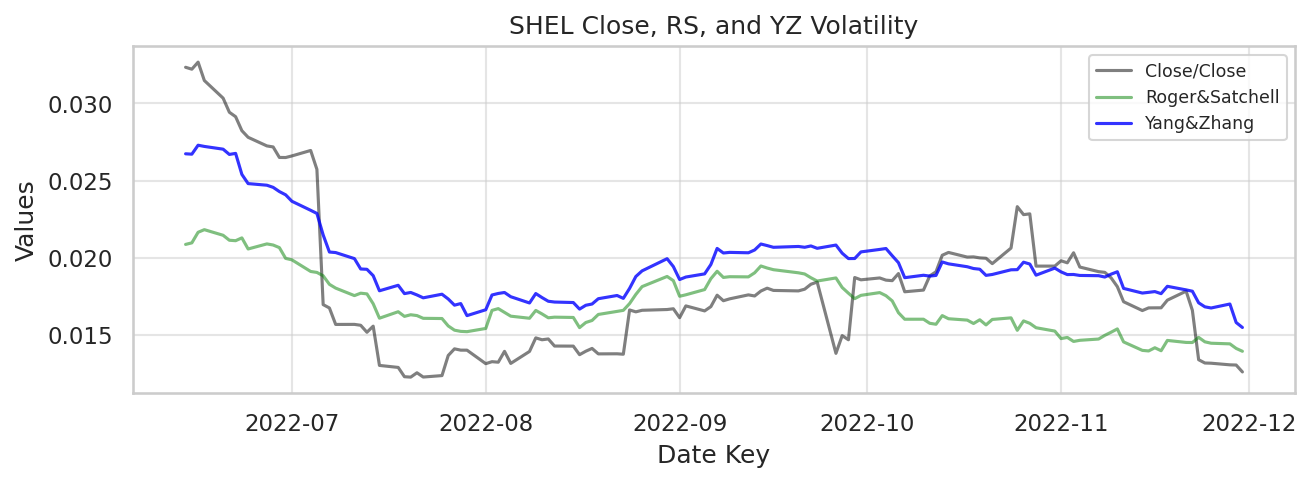

In [98]:
ticker = 'SHEL'
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == ticker]
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 3))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close', color = 'black', alpha = 0.5)
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell', color = 'green', alpha = 0.5)
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang', color = 'blue', alpha = 0.8)

# Optionally, add grid
plt.grid(True, alpha = 0.5)

# Add legend to distinguish each line
plt.legend(fontsize = 'x-small')

# Add title and labels
plt.title(f'{ticker} Close, RS, and YZ Volatility')
plt.xlabel('Date Key')
plt.ylabel('Values')

# Display the plot
plt.show()

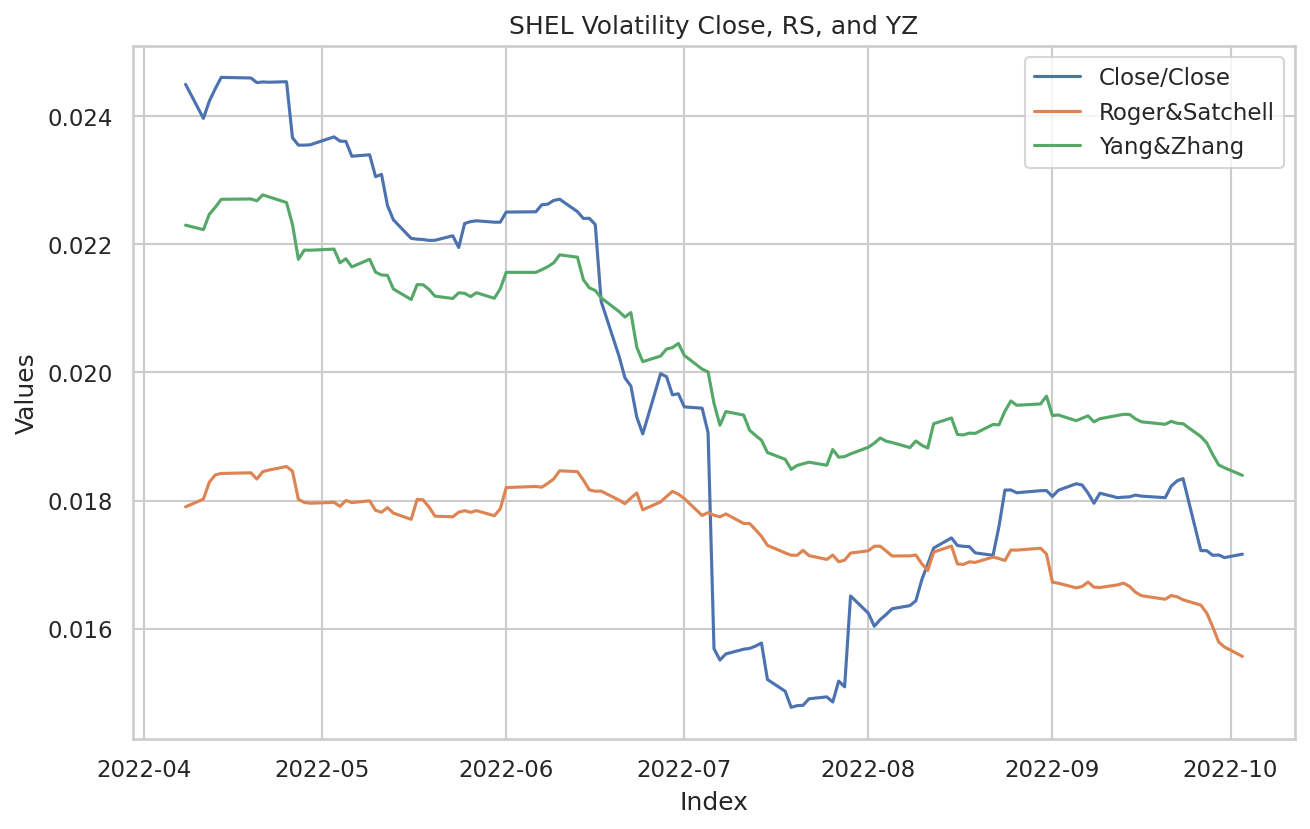

In [81]:
ticker = 'SHEL'
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == ticker]
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close')
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell')
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title(f'{ticker} Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

## Tate

/tmp/ipykernel_224941/3586328959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)


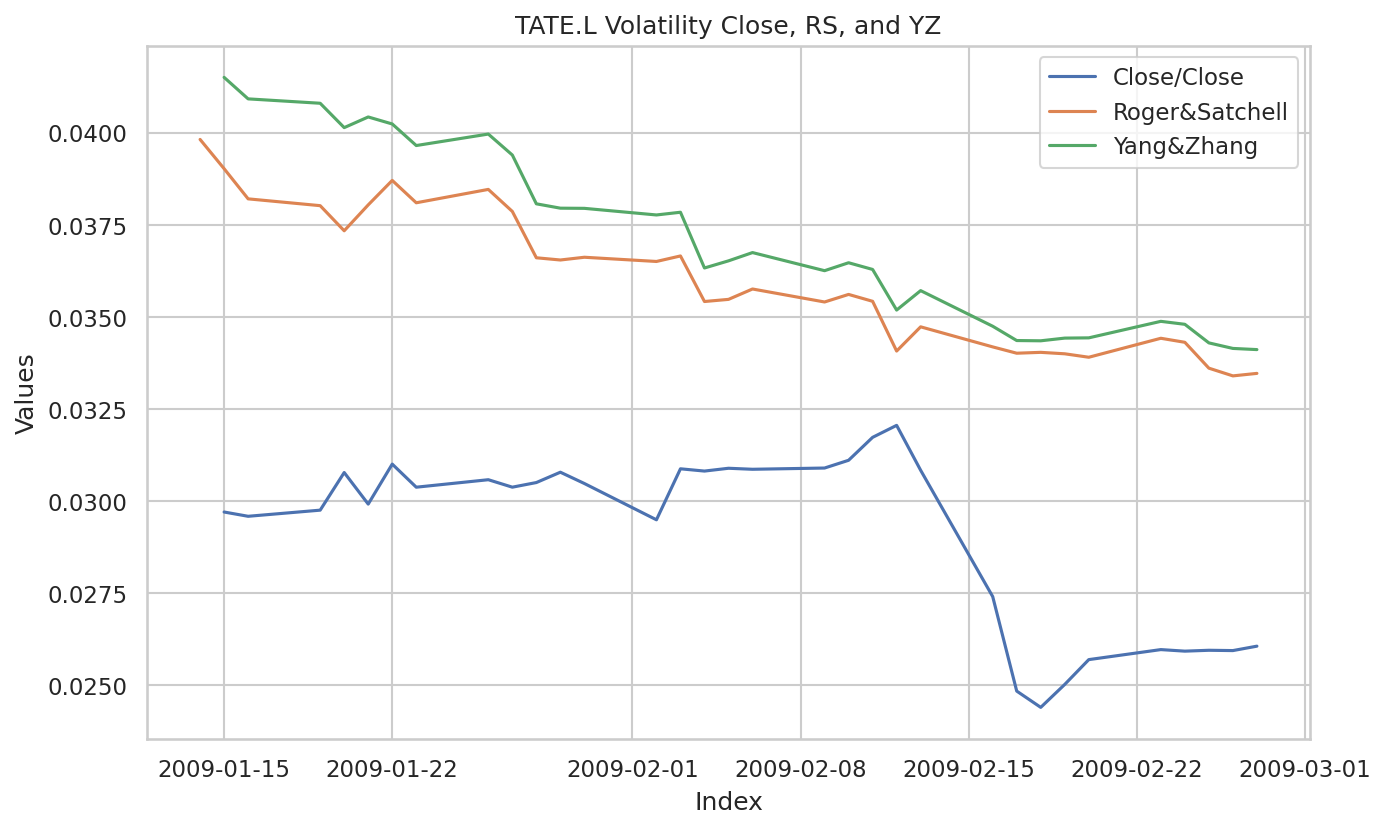

In [19]:
name = ftse_volprice_df[ftse_volprice_df['Asset'] == 4295894759].loc[440, 'RIC']

temp_shel_df = ftse_volprice_df[ftse_volprice_df['Asset'] == 4295894759]
# temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[(temp_shel_df.index >= '2009-01-01') & (temp_shel_df.index <= '2011-07-01')]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close')
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell')
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title(f'{name} Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

## Astra Zeneca

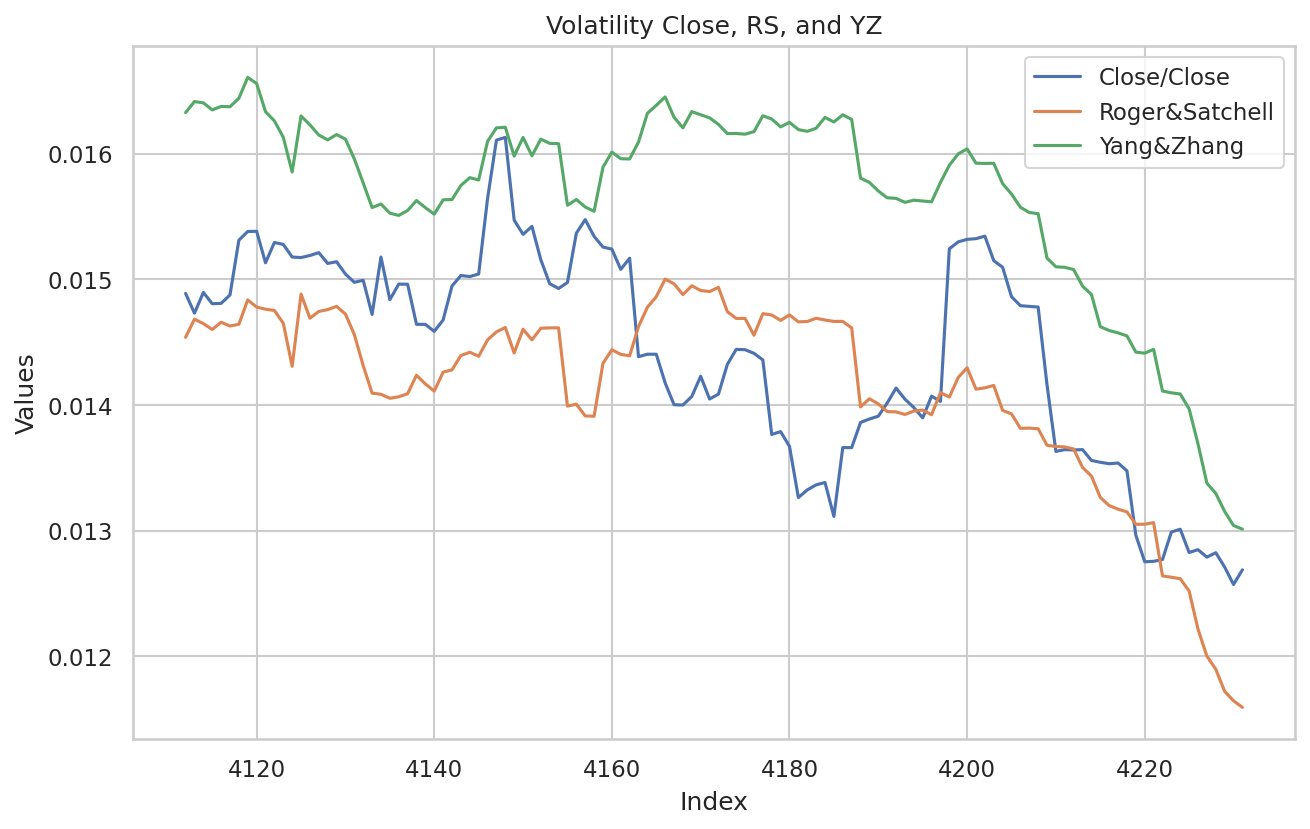

In [80]:
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == 'AZN']
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)
temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close')
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell')
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title('Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

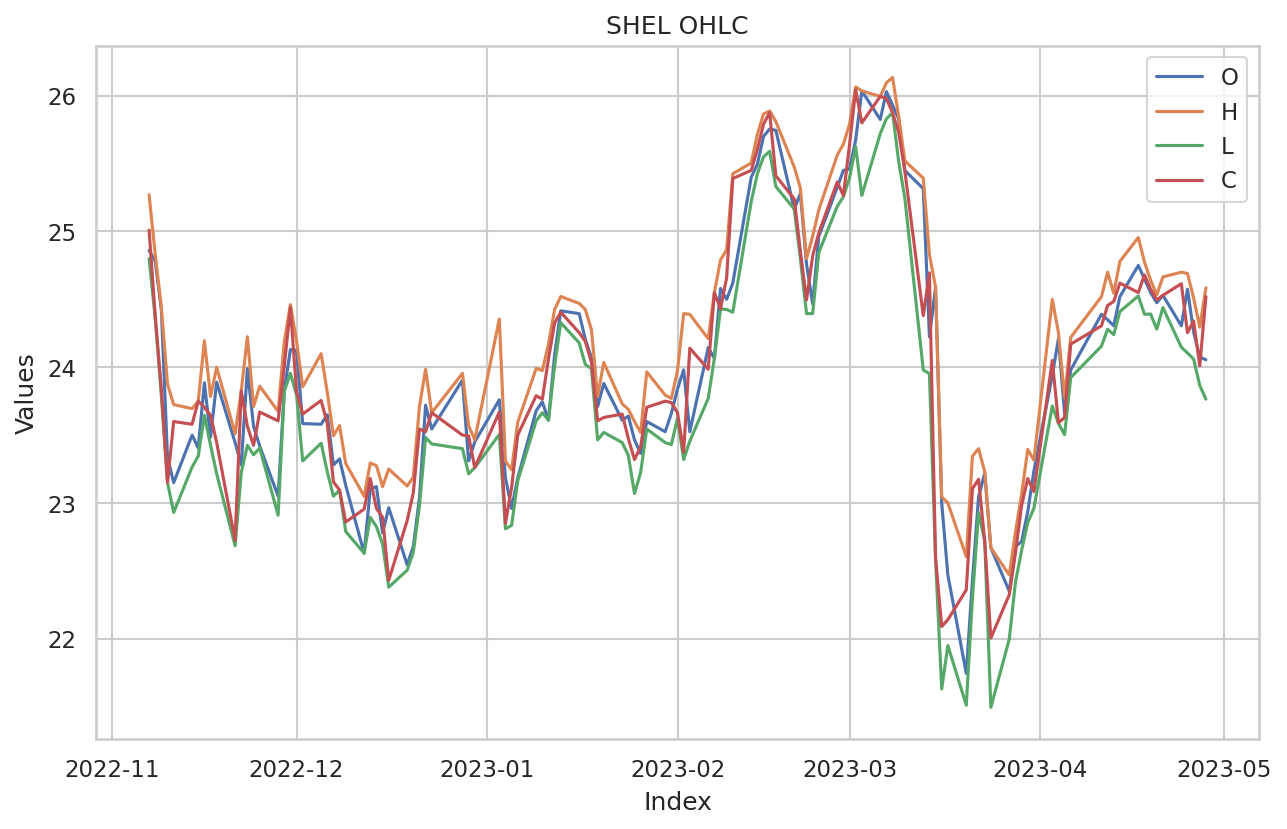

In [12]:
ticker = 'SHEL'
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == ticker]
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['Open'], label='O')
plt.plot(temp_shel_df['High'], label='H')
plt.plot(temp_shel_df['Low'], label='L')
plt.plot(temp_shel_df['Close'], label='C')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title(f'{ticker} OHLC')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

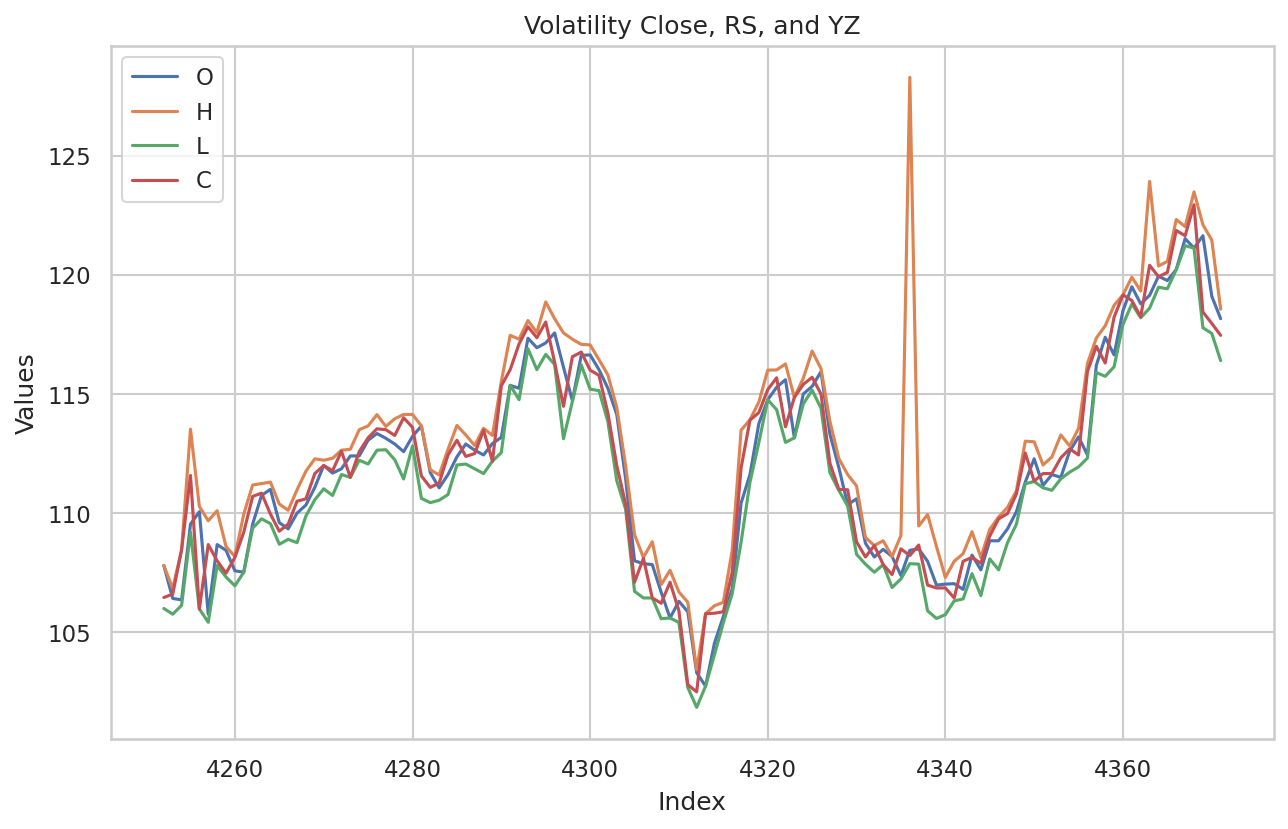

In [10]:
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == 'AZN']
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)
temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['Open'], label='O')
plt.plot(temp_shel_df['High'], label='H')
plt.plot(temp_shel_df['Low'], label='L')
plt.plot(temp_shel_df['Close'], label='C')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title('Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

In [11]:
ftse_volprice_df.to_csv('files/1.1-FTSE_VOL-PRICES_2006-2023.csv', index=None)

In [12]:
ftse_volprice_df.to_csv('files/1.1-FTSE_VOL30-PRICES_2006-2022.csv', index=None)

---

# Check one

In [23]:
ftse_volprice_df.head(2)

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
0,2006-01-01,2006-01-03 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.384185,9.486490,9.365584,9.486490,2.503309e+06,10.20,False,0,NaN,NaN,NaN,0.010843,-0.001984,0.010843,NaN,NaN,0.000025,NaN,NaN,NaN
1,2006-01-01,2006-01-04 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.505091,9.663199,9.505091,9.616697,2.410045e+06,10.34,False,0,0.013725,9.48649,0.001959,0.016497,0.000000,0.011673,NaN,NaN,0.000080,NaN,NaN,NaN


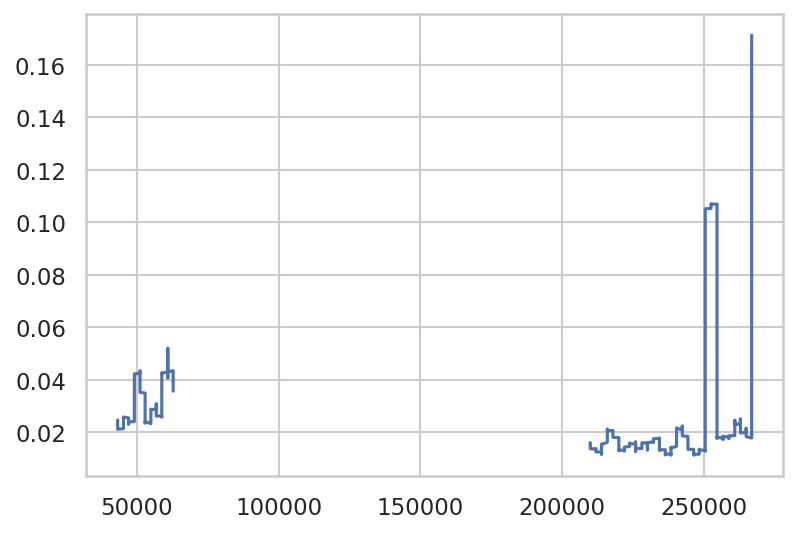

In [22]:
# this is 
plt.plot(ftse_volprice_df[ftse_volprice_df['Asset'] == 5000683618]['V^YZ'])

# Volatility Calculation for Index

## FTSE

In [24]:
indexes_df = pd.read_csv('files/1.0-indexes_price.csv')

In [25]:
FTSE_df = indexes_df[indexes_df['Name'] == '^FTSE']

In [26]:
FTSE_vol_df = func_Vol_YangZhang(FTSE_df, rolling = 30, blank_days=30, assets='Name')

In [27]:
FTSE_vol_df.to_csv('files/1.1-FTSE-IDX_VOL30-PRICES_2006-2023.csv')

# Checks of Volatility using Groups

In [ ]:
test_df = ftse_price_df[ftse_price_df['Asset'] == 5000683618]
test_df.loc[:, 'Date'] = pd.to_datetime(test_df['Date'])
test_df.index = pd.to_datetime(test_df['Date'])

blank_days = 30
test_df.loc[:,'Jump'] = test_df['Date'].diff() > timedelta(days=blank_days)
test_df.loc[:,'Group'] = test_df['Jump'].cumsum()

test_df['Close_t-1'] = test_df.groupby('Group')['Close'].shift(1)



slice_df.groupby('Group').apply(normalised_open).droplevel('Group')

test_df.groupby('Group').apply(normalised_open).droplevel('Group')

rolling=30
test_df.loc[:, 'new'] = test_df.groupby('Group')['O_i'].rolling(window=rolling).std().droplevel('Group')

test_df.groupby('Group').rolling(window=rolling)['O_i']

test_df.groupby('Group')['O_i'].rolling(window=rolling).mean()

# Barclays Check Finished
<!-- https://docs.google.com/spreadsheets/d/1kur8YCg_X9QdlXLz6f0014bk4DPjY6DIxnnaG93LS7Y/edit#gid=1411703208 -->

In [26]:
temp_df = ftse_price_df[ftse_price_df['Asset'] == 8589934333]

In [32]:
temp_process_df = func_Vol_YangZhang(temp_df, rolling=5)

In [33]:
temp_process_df.head(50)

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
1929,2006-01-01,2006-01-03 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.546110,5.586592,5.501129,5.555106,4.232327e+07,6.174998,False,0,NaN,NaN,NaN,0.007273,-0.008143,0.001621,NaN,NaN,0.000121,NaN,NaN,NaN
1930,2006-01-01,2006-01-04 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.604585,5.649565,5.564102,5.640569,4.149206e+07,6.269998,False,0,0.015385,5.555106,0.008867,0.007994,-0.007249,0.006400,NaN,NaN,0.000112,NaN,NaN,NaN
1931,2006-01-01,2006-01-05 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.640569,5.645067,5.586592,5.591090,4.242793e+07,6.214998,False,0,-0.008772,5.640569,0.000000,0.000797,-0.009615,-0.008811,NaN,NaN,0.000015,NaN,NaN,NaN
1932,2006-01-01,2006-01-06 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.604585,5.645067,5.595588,5.645067,3.620193e+07,6.274998,False,0,0.009654,5.591090,0.002411,0.007197,-0.001606,0.007197,NaN,NaN,0.000014,NaN,NaN,NaN
1933,2006-01-01,2006-01-09 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.667558,5.667558,5.555106,5.649565,6.135795e+07,6.279998,False,0,0.000797,5.645067,0.003976,0.000000,-0.020041,-0.003180,NaN,0.006728,0.000338,NaN,0.010952,NaN
1934,2006-01-01,2006-01-10 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.631573,5.631573,5.555106,5.568600,3.938591e+07,6.189998,False,0,-0.014331,5.649565,-0.003190,0.000000,-0.013671,-0.011245,0.004509,0.008491,0.000033,0.012363,0.010122,0.010916
1935,2006-01-01,2006-01-11 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.618079,5.654063,5.577596,5.636071,2.385333e+07,6.264998,False,0,0.012116,5.568600,0.008846,0.006385,-0.007232,0.003197,0.004501,0.007798,0.000096,0.011434,0.009964,0.010721
1936,2006-01-01,2006-01-12 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.636071,5.694546,5.618079,5.654063,2.954940e+07,6.284998,False,0,0.003192,5.636071,0.000000,0.010322,-0.003197,0.003187,0.004501,0.007222,0.000094,0.010369,0.010724,0.011302
1937,2006-01-01,2006-01-13 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.645067,5.663059,5.568600,5.586592,2.644891e+07,6.209998,False,0,-0.011933,5.654063,-0.001592,0.003182,-0.013638,-0.010413,0.004844,0.007023,0.000087,0.011009,0.011386,0.011978
1938,2006-01-01,2006-01-16 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.586592,5.591090,5.532616,5.582094,1.836258e+07,6.204998,False,0,-0.000805,5.586592,0.000000,0.000805,-0.009709,-0.000805,0.004681,0.007145,0.000088,0.010929,0.008922,0.009904


---

<Axes: xlabel='Date (shifted)'>

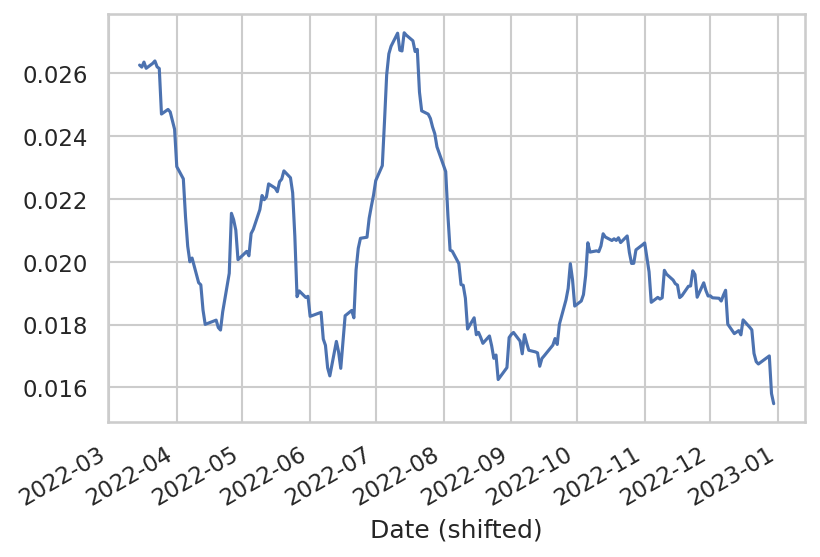

In [82]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 21)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
vol_days21 = ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2]
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2].plot()

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Date (shifted)'>

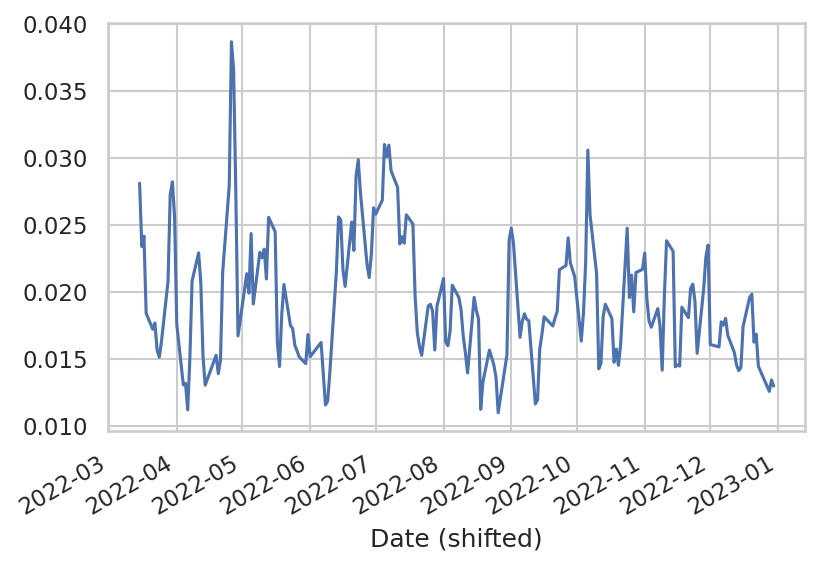

In [7]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 3)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
vol_days3 = ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2]
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2].plot()

<Axes: xlabel='Date (shifted)'>

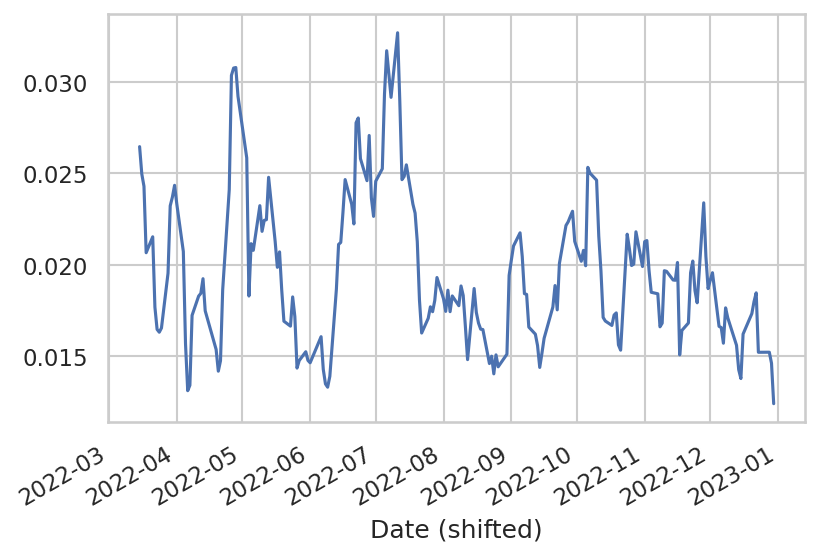

In [8]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 5)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
vol_days5 = ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2]
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2].plot()

<Axes: xlabel='Date (shifted)'>

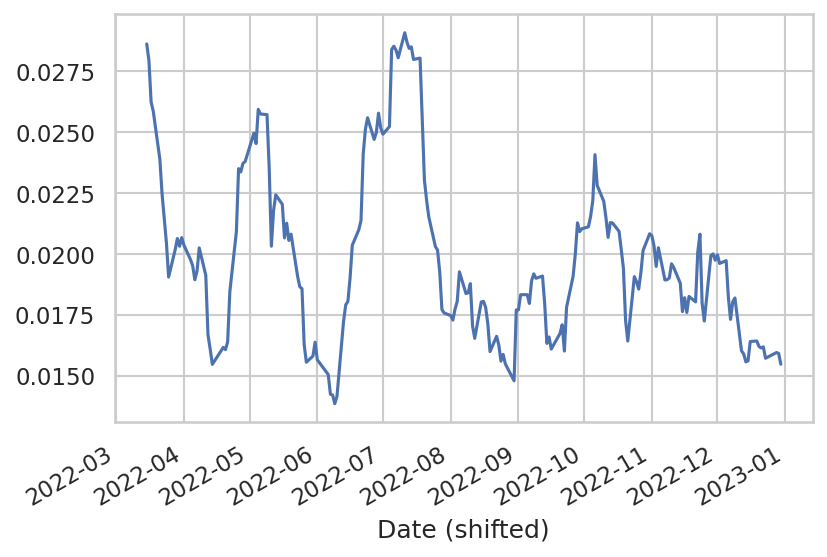

In [10]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 10)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
vol_days10 = ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2]
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2].plot()

<Axes: xlabel='Date (shifted)'>

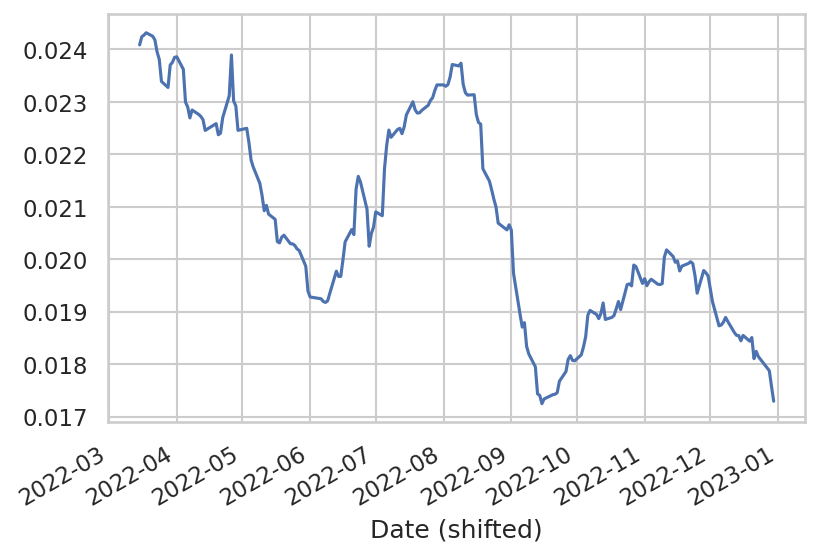

In [11]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 42)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
vol_days42 = ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2]
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2].plot()

<Axes: xlabel='Date (shifted)'>

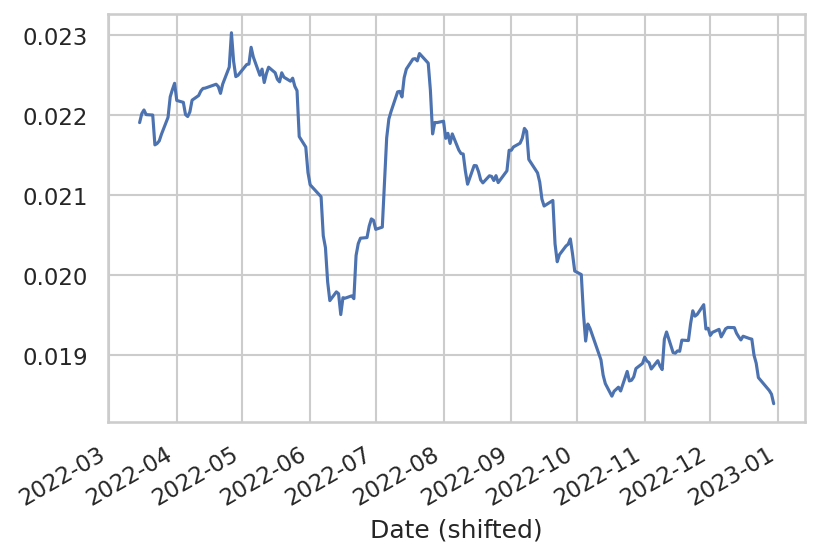

In [12]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 63)
ftse_volprice_df.index = pd.to_datetime(ftse_volprice_df['Date (shifted)'])
vol_days63 = ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2]
ftse_volprice_df[(ftse_volprice_df['Ticker'] == 'SHEL') & (ftse_volprice_df['V^YZ'].notnull())].iloc[(-200):, -2].plot()

---

In [26]:
compile_volatility_df = pd.concat([vol_days3, vol_days10, vol_days21,  vol_days63], axis=1)
compile_volatility_df.columns = ['V^YZ (3d)', 'V^YZ (10d)', 'V^YZ (21d)', 'V^YZ (63d)']

In [39]:
compile_volatility_df.index = pd.to_datetime(compile_volatility_df.index)

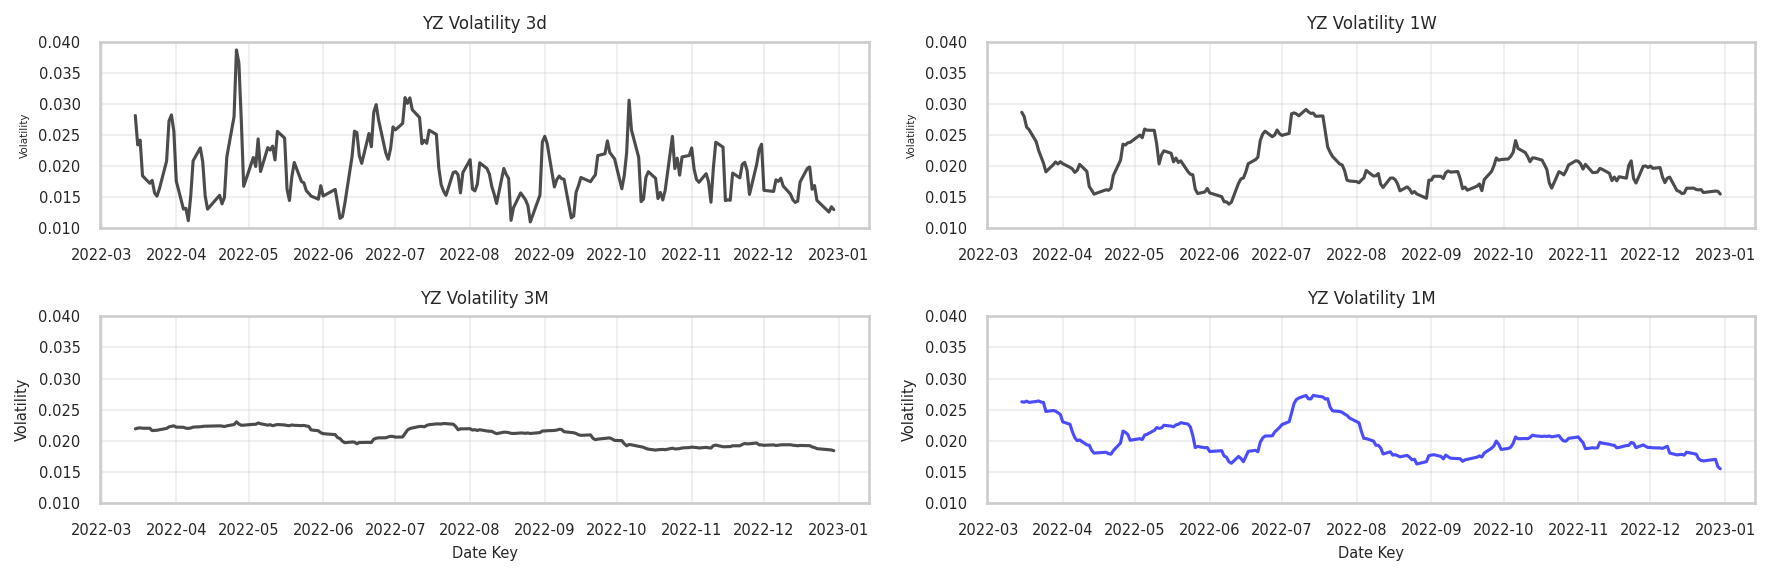

In [97]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,2, figsize = (12, 4))

# Plot data in the first subplot
axs[0,0].plot(compile_volatility_df['V^YZ (3d)'], color = 'black', alpha = 0.7)
axs[0,0].set_title('YZ Volatility 3d', fontsize = 8)
axs[0,0].set_ylabel('Volatility', fontsize = 5)
axs[0,0].tick_params(axis='x', labelsize=7)
axs[0,0].tick_params(axis='y', labelsize=7)
axs[0,0].grid(axis = 'y', alpha = 0.3)
axs[0,0].grid(axis = 'x', alpha = 0.3)
axs[0,0].set_ylim(0.01, 0.04)

# Plot data in the first subplot
axs[0,1].plot(compile_volatility_df['V^YZ (10d)'], color = 'black', alpha = 0.7)
axs[0,1].set_title('YZ Volatility 1W', fontsize = 8)
axs[0,1].set_ylabel('Volatility', fontsize = 5)
axs[0,1].tick_params(axis='x', labelsize=7)
axs[0,1].tick_params(axis='y', labelsize=7)
axs[0,1].grid(axis = 'y', alpha = 0.3)
axs[0,1].grid(axis = 'x', alpha = 0.3)
axs[0,1].set_ylim(0.01, 0.04)

# Plot data in the first subplot
axs[1,1].plot(compile_volatility_df['V^YZ (21d)'], color = 'blue', alpha = 0.7)
axs[1,1].set_title('YZ Volatility 1M', fontsize = 8)
axs[1,1].set_ylabel('Volatility', fontsize = 7)
axs[1,1].set_xlabel('Date Key', fontsize = 7)
axs[1,1].tick_params(axis='x', labelsize=7)
axs[1,1].tick_params(axis='y', labelsize=7)
axs[1,1].grid(axis = 'y', alpha = 0.3)
axs[1,1].grid(axis = 'x', alpha = 0.3)
axs[1,1].set_ylim(0.01, 0.04)

# Plot data in the first subplot
axs[1,0].plot(compile_volatility_df['V^YZ (63d)'], color = 'black', alpha = 0.7)
axs[1,0].set_title('YZ Volatility 3M', fontsize = 8)
axs[1,0].set_ylabel('Volatility', fontsize = 7)
axs[1,0].set_xlabel('Date Key', fontsize = 7)
axs[1,0].tick_params(axis='x', labelsize=7)
axs[1,0].tick_params(axis='y', labelsize=7)
axs[1,0].grid(axis = 'y', alpha = 0.3)
axs[1,0].grid(axis = 'x', alpha = 0.3)
axs[1,0].set_ylim(0.01, 0.04)

# Show the figure
plt.tight_layout()
plt.show()

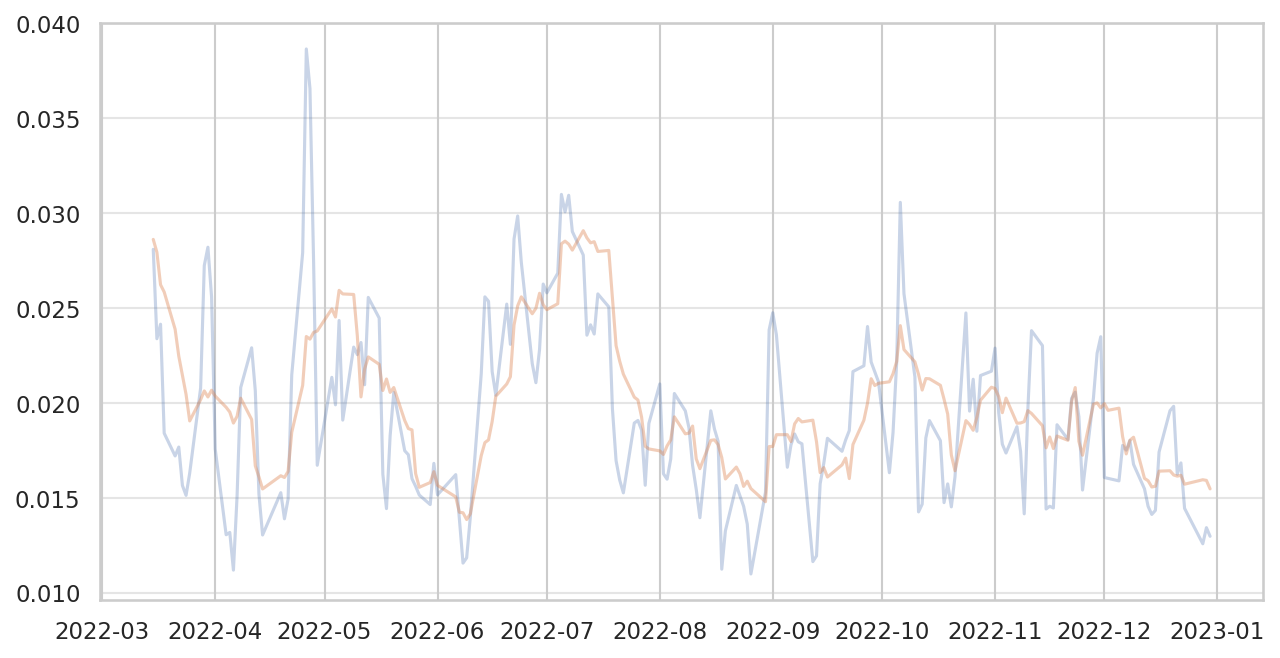

In [34]:
plt.figure(figsize=(10,5))
plt.plot(compile_volatility_df['V^YZ (3d)'], alpha = 0.3)
plt.plot(compile_volatility_df['V^YZ (10d)'], alpha = 0.4)
plt.grid(axis='y', alpha=0.5)